In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
import zipfile

# Unzip train.zip
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/temp/training')

# Unzip test1.zip
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/temp/testing')


## Importing Required Libraries

In [3]:
import os
import random
import shutil
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split




2024-03-31 20:45:27.433745: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 20:45:27.433845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 20:45:27.567432: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load and Prepare the Data

In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split


# Define paths and constants
TRAIN_DIR = '/kaggle/temp/training/train/'  # Directory where the training images are located
TEST_DIR = '/kaggle/temp/testing/test1/'   # Directory where the testing images are located
IMG_SIZE = 100  # Size to which images will be resized

# Function to load and preprocess images
def load_images(directory, img_size):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg'):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (img_size, img_size))

            images.append(img)
            if 'dog' in filename:
                labels.append(1)  # Dogs labeled as 1
            elif 'cat' in filename:
                labels.append(0)  # Cats labeled as 0

    return np.array(images), np.array(labels)



In [5]:
# Load and preprocess training images
train_images, train_labels = load_images(TRAIN_DIR, IMG_SIZE)
test_images, _ = load_images(TEST_DIR, IMG_SIZE)  # For test data, we might not have labels

# Print out the shape to confirm loading
print("Training Images shape:", train_images.shape)
print("Training Labels shape:", train_labels.shape)
print("Test Images shape:", test_images.shape)

Training Images shape: (25000, 100, 100, 3)
Training Labels shape: (25000,)
Test Images shape: (12500, 100, 100, 3)


In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

random_state = np.random.seed(42)  # Define random_state for reproducibility

# Split the original training data to get a subset of 1000 images for training
train_images_subset, remaining_images, train_labels_subset, remaining_labels = train_test_split(
    train_images, train_labels, 
    train_size=1000, random_state=random_state, stratify=train_labels)

# From the remaining images, split out 500 for validation
val_images_subset, _, val_labels_subset, _ = train_test_split(
    remaining_images, remaining_labels, 
    train_size=500/len(remaining_images), random_state=random_state, stratify=remaining_labels)

test_images_subset = test_images[:500]  # Selecting the first 500 images for testing

print("Subset - Training Images shape:", train_images_subset.shape)
print("Subset - Training Labels shape:", train_labels_subset.shape)
print("Subset - Validation Images shape:", val_images_subset.shape)
print("Subset - Validation Labels shape:", val_labels_subset.shape)
print("Subset - Test Images shape:", test_images_subset.shape)


Subset - Training Images shape: (1000, 100, 100, 3)
Subset - Training Labels shape: (1000,)
Subset - Validation Images shape: (500, 100, 100, 3)
Subset - Validation Labels shape: (500,)
Subset - Test Images shape: (500, 100, 100, 3)


##### Model Architecture

##### Compiling the model

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation data


##### Model Training

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Adjusted model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), input_shape=(100, 100, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters=64, kernel_size=(3,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid')) 

# Setting up the optimizer
optimizer = Adam()

# Compiling the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(
    train_datagen.flow(train_images_subset, train_labels_subset, batch_size=20),
    epochs=20,  # Adjust the number of epochs as needed
    validation_data=val_datagen.flow(val_images_subset, val_labels_subset, batch_size=20),
    verbose=1
)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-03-31 20:46:53.208547: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 28812: 6.11738, expected 5.37229
2024-03-31 20:46:53.208602: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 28814: 6.21141, expected 5.46631
2024-03-31 20:46:53.208611: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 28820: 6.16714, expected 5.42204
2024-03-31 20:46:53.208619: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 28823: 5.81356, expected 5.06847
2024-03-31 20:46:53.208627: E external/local_xla/xla/service/gpu/buffer_

 5/50 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4243 - loss: 1.1064

I0000 00:00:1711918017.701794      84 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - accuracy: 0.5480 - loss: 0.9186 - val_accuracy: 0.5000 - val_loss: 0.8776
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.5953 - loss: 0.7268 - val_accuracy: 0.5000 - val_loss: 0.9888
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6118 - loss: 0.6957 - val_accuracy: 0.5000 - val_loss: 1.0081
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.6185 - loss: 0.6951 - val_accuracy: 0.5000 - val_loss: 0.8703
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6519 - loss: 0.6461 - val_accuracy: 0.4980 - val_loss: 0.8724
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6483 - loss: 0.6430 - val_accuracy: 0.4980 - val_loss: 0.8602
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6929 - loss: 0.5917 - val_accuracy: 0.5380 - val_loss: 0.7884
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6667 - loss: 0.6053 - val_accuracy: 0.6260 - val_loss: 0

In [9]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_datagen.flow(val_images_subset, val_labels_subset, batch_size=20))
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6459 - loss: 0.6600
Validation Accuracy: 66.00%


In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)
predictions = model.predict(test_datagen.flow(test_images, batch_size=20, shuffle=False))

# Assuming binary classification and using 0.5 as the threshold
predicted_labels = (predictions > 0.5).astype("int32")


625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


## Step 2

In [11]:
from sklearn.model_selection import train_test_split

# Assuming train_images and train_labels are your full training dataset
train_images_larger_subset, _, train_labels_larger_subset, _ = train_test_split(
    train_images, train_labels, 
    train_size=5000, random_state=random_state, stratify=train_labels)


In [12]:
# use of the previously defined model architecture
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Fitting the model with the larger training set
history_larger = model.fit(
    train_datagen.flow(train_images_larger_subset, train_labels_larger_subset, batch_size=20),
    epochs=20,  # Adjust the number of epochs as needed
    validation_data=val_datagen.flow(val_images_subset, val_labels_subset, batch_size=20),
    verbose=1
)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 49ms/step - accuracy: 0.6334 - loss: 0.6421 - val_accuracy: 0.6780 - val_loss: 0.6283
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.6536 - loss: 0.6083 - val_accuracy: 0.6140 - val_loss: 0.6943
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.6706 - loss: 0.6028 - val_accuracy: 0.6920 - val_loss: 0.5585
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.6971 - loss: 0.5786 - val_accuracy: 0.6980 - val_loss: 0.5908
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.7028 - loss: 0.5681 - val_accuracy: 0.6580 - val_loss: 0.6548
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.6943 - loss: 0.5819 - val_accuracy: 0.7020 - val_loss: 0.5838
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.6817 - loss: 0.5721 - val_accuracy: 0.7240 - val_loss: 0.5483
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.6935 - loss: 0.5658 - val_accurac

In [13]:
val_loss_larger, val_accuracy_larger = model.evaluate(val_datagen.flow(val_images_subset, val_labels_subset, batch_size=20))
print(f"Validation Accuracy with larger training set: {val_accuracy_larger*100:.2f}%")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6993 - loss: 0.5687
Validation Accuracy with larger training set: 69.00%


## Step 3

In [14]:
train_images_subset_1500, _, train_labels_subset_1500, _ = train_test_split(
    train_images, train_labels, 
    train_size=10000, random_state=random_state, stratify=train_labels)


In [15]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history_1500 = model.fit(
    train_datagen.flow(train_images_subset_1500, train_labels_subset_1500, batch_size=20),
    epochs=20,
    validation_data=val_datagen.flow(val_images_subset, val_labels_subset, batch_size=20),
    verbose=1
)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.7184 - loss: 0.5451 - val_accuracy: 0.7200 - val_loss: 0.5470
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.7302 - loss: 0.5360 - val_accuracy: 0.7320 - val_loss: 0.5151
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.7321 - loss: 0.5335 - val_accuracy: 0.7260 - val_loss: 0.5293
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.7361 - loss: 0.5277 - val_accuracy: 0.7760 - val_loss: 0.5010
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.7318 - loss: 0.5240 - val_accuracy: 0.7120 - val_loss: 0.5870
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.7525 - loss: 0.5124 - val_accuracy: 0.7560 - val_loss: 0.5010
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.7404 - loss: 0.5116 - val_accuracy: 0.7620 - val_loss: 0.4879
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.7442 - loss: 0.5097 - val_accurac

In [16]:
val_loss_10000, val_accuracy_10000 = model.evaluate(val_datagen.flow(val_images_subset, val_labels_subset, batch_size=20))
print(f"Validation Accuracy with 10000 training samples: {val_accuracy_10000*100:.2f}%")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7228 - loss: 0.5489
Validation Accuracy with 10000 training samples: 72.60%


## Step 4

In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Freeze the layers of the base model
for layer in vgg_base.layers:
    layer.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
model = Sequential([
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


### 1. Step 1 (repeated)

In [19]:
history_1000 = model.fit(
    train_datagen.flow(train_images_subset, train_labels_subset, batch_size=20),
    epochs=20,
    validation_data=val_datagen.flow(val_images_subset, val_labels_subset, batch_size=20),
    verbose=1
)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.5505 - loss: 0.9740 - val_accuracy: 0.7200 - val_loss: 0.5607
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6773 - loss: 0.6089 - val_accuracy: 0.6880 - val_loss: 0.5728
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6867 - loss: 0.5771 - val_accuracy: 0.7680 - val_loss: 0.5044
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7137 - loss: 0.5384 - val_accuracy: 0.7840 - val_loss: 0.4874
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7427 - loss: 0.5201 - val_accuracy: 0.7240 - val_loss: 0.5235
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7227 - loss: 0.5415 - val_accuracy: 0.7820 - val_loss: 0.4667
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.7400 - loss: 0.5279 - val_accuracy: 0.7600 - val_loss: 0.5141
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.7485 - loss: 0.4934 - val_accuracy: 0.7900 - 

In [20]:
val_loss_1000, val_accuracy_1000 = model.evaluate(val_datagen.flow(val_images_subset, val_labels_subset, batch_size=20))
print(f"Validation Accuracy with 1000 training samples: {val_accuracy_1000*100:.2f}%")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7830 - loss: 0.4456
Validation Accuracy with 1000 training samples: 78.40%


### 2. Step 2 repeated

In [21]:
train_images_subset_5000, _, train_labels_subset_5000, _ = train_test_split(
    train_images, train_labels, 
    train_size=5000, random_state=random_state, stratify=train_labels)


In [22]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history_5000 = model.fit(
    train_datagen.flow(train_images_subset_5000, train_labels_subset_5000, batch_size=20),
    epochs=20,
    validation_data=val_datagen.flow(val_images_subset, val_labels_subset, batch_size=20),
    verbose=1
)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.7470 - loss: 0.5301 - val_accuracy: 0.8140 - val_loss: 0.4284
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.7320 - loss: 0.5241 - val_accuracy: 0.7940 - val_loss: 0.4429
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.7550 - loss: 0.5111 - val_accuracy: 0.8200 - val_loss: 0.4058
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.7637 - loss: 0.4944 - val_accuracy: 0.8060 - val_loss: 0.4076
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.7510 - loss: 0.5034 - val_accuracy: 0.8140 - val_loss: 0.4091
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.7650 - loss: 0.4742 - val_accuracy: 0.8100 - val_loss: 0.4154
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.7570 - loss: 0.4933 - val_accuracy: 0.8040 - val_loss: 0.4071
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.7789 - loss: 0.4677 - val_accurac

In [23]:
# Make sure to use the model trained with 5000 samples here
val_loss_5000, val_accuracy_5000 = model.evaluate(val_datagen.flow(val_images_subset, val_labels_subset, batch_size=20))
print(f"Validation Accuracy with 5000 training samples: {val_accuracy_5000*100:.2f}%")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8096 - loss: 0.4119
Validation Accuracy with 5000 training samples: 82.20%


### 3. Step 3(repeated)

In [24]:
train_images_subset_1500, _, train_labels_subset_1500, _ = train_test_split(
    train_images, train_labels, 
    train_size=10000, random_state=random_state, stratify=train_labels)


In [25]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history_1500 = model.fit(
    train_datagen.flow(train_images_subset_1500, train_labels_subset_1500, batch_size=20),
    epochs=20,
    validation_data=val_datagen.flow(val_images_subset, val_labels_subset, batch_size=20),
    verbose=1
)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 50ms/step - accuracy: 0.7714 - loss: 0.4826 - val_accuracy: 0.8240 - val_loss: 0.4074
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.7644 - loss: 0.4803 - val_accuracy: 0.8200 - val_loss: 0.3962
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.7822 - loss: 0.4651 - val_accuracy: 0.8120 - val_loss: 0.3850
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.7800 - loss: 0.4629 - val_accuracy: 0.8100 - val_loss: 0.3852
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.7867 - loss: 0.4558 - val_accuracy: 0.8160 - val_loss: 0.3936
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.7776 - loss: 0.4581 - val_accuracy: 0.8320 - val_loss: 0.3734
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.7944 - loss: 0.4497 - val_accuracy: 0.8400 - val_loss: 0.3831
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.7862 - loss: 0.4664 - val_accurac

In [26]:
# Use the model trained with 1500 samples
val_loss_10000, val_accuracy_10000 = model.evaluate(val_datagen.flow(val_images_subset, val_labels_subset, batch_size=20))
print(f"Validation Accuracy with 10000 training samples: {val_accuracy_10000*100:.2f}%")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8288 - loss: 0.3840
Validation Accuracy with 10000 training samples: 83.60%


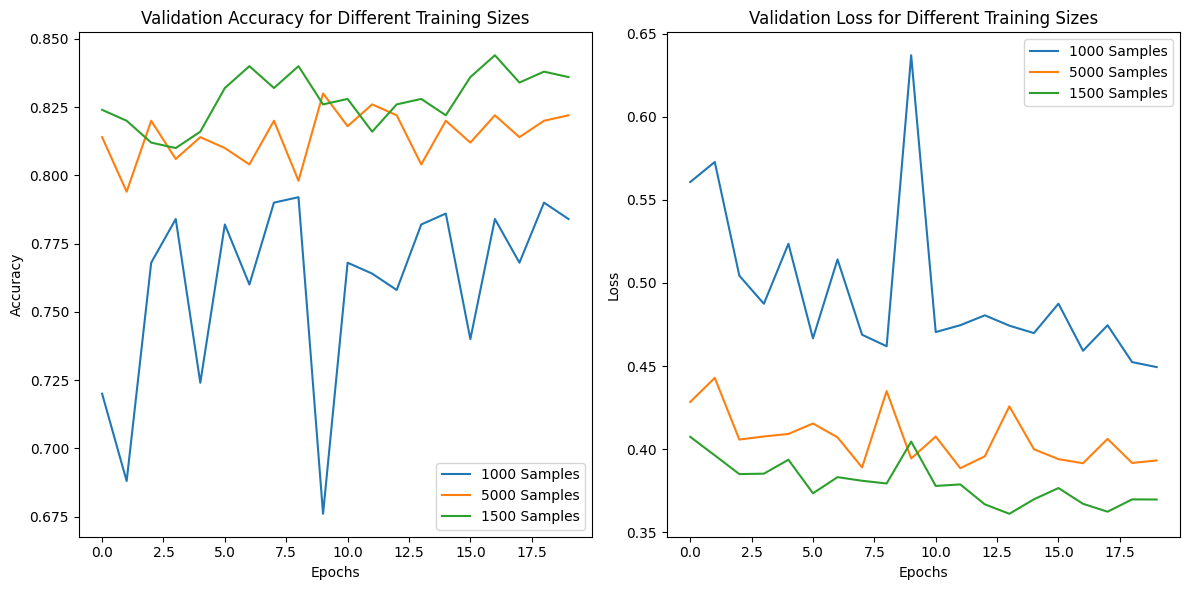

In [27]:
import matplotlib.pyplot as plt

# Plot Validation Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_1000.history['val_accuracy'], label='1000 Samples')
plt.plot(history_5000.history['val_accuracy'], label='5000 Samples')
plt.plot(history_1500.history['val_accuracy'], label='1500 Samples')
plt.title('Validation Accuracy for Different Training Sizes')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_1000.history['val_loss'], label='1000 Samples')
plt.plot(history_5000.history['val_loss'], label='5000 Samples')
plt.plot(history_1500.history['val_loss'], label='1500 Samples')
plt.title('Validation Loss for Different Training Sizes')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
